In [3]:
import mdptoolbox.mdp as mdp
import mdptoolbox.example as example
import mdptoolbox.util as _util
import numpy as np
import matplotlib.pyplot as plt
import time

In [173]:
mdp._version_

AttributeError: module 'mdptoolbox.mdp' has no attribute '_version_'

In [4]:
# -*- coding: utf-8 -*-
"""Markov Decision Process (MDP) Toolbox: ``mdp`` module
=====================================================

The ``mdp`` module provides classes for the resolution of descrete-time Markov
Decision Processes.

Available classes
-----------------
:class:`~mdptoolbox.mdp.MDP`
    Base Markov decision process class
:class:`~mdptoolbox.mdp.FiniteHorizon`
    Backwards induction finite horizon MDP
:class:`~mdptoolbox.mdp.PolicyIteration`
    Policy iteration MDP
:class:`~mdptoolbox.mdp.PolicyIterationModified`
    Modified policy iteration MDP
:class:`~mdptoolbox.mdp.QLearning`
    Q-learning MDP
:class:`~mdptoolbox.mdp.RelativeValueIteration`
    Relative value iteration MDP
:class:`~mdptoolbox.mdp.ValueIteration`
    Value iteration MDP
:class:`~mdptoolbox.mdp.ValueIterationGS`
    Gauss-Seidel value iteration MDP

"""

# Copyright (c) 2011-2015 Steven A. W. Cordwell
# Copyright (c) 2009 INRA
#
# All rights reserved.
#
# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:
#
#   * Redistributions of source code must retain the above copyright notice,
#     this list of conditions and the following disclaimer.
#   * Redistributions in binary form must reproduce the above copyright notice,
#     this list of conditions and the following disclaimer in the documentation
#     and/or other materials provided with the distribution.
#   * Neither the name of the <ORGANIZATION> nor the names of its contributors
#     may be used to endorse or promote products derived from this software
#     without specific prior written permission.
#
# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE
# ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE
# LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR
# CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF
# SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS
# INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN
# CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE)
# ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE
# POSSIBILITY OF SUCH DAMAGE.

import math as _math
import time as _time

import numpy as _np
import scipy.sparse as _sp

import mdptoolbox.util as _util

_MSG_STOP_MAX_ITER = "Iterating stopped due to maximum number of iterations " \
    "condition."
_MSG_STOP_EPSILON_OPTIMAL_POLICY = "Iterating stopped, epsilon-optimal " \
    "policy found."
_MSG_STOP_EPSILON_OPTIMAL_VALUE = "Iterating stopped, epsilon-optimal value " \
    "function found."
_MSG_STOP_UNCHANGING_POLICY = "Iterating stopped, unchanging policy found."


def _computeDimensions(transition):
    A = len(transition)
    try:
        if transition.ndim == 3:
            S = transition.shape[1]
        else:
            S = transition[0].shape[0]
    except AttributeError:
        S = transition[0].shape[0]
    return S, A


def _printVerbosity(iteration, variation):
    if isinstance(variation, float):
        print("{:>10}{:>12f}".format(iteration, variation))
    elif isinstance(variation, int):
        print("{:>10}{:>12d}".format(iteration, variation))
    else:
        print("{:>10}{:>12}".format(iteration, variation))

class MDP(object):

    """A Markov Decision Problem.

    Let ``S`` = the number of states, and ``A`` = the number of acions.

    Parameters
    ----------
    transitions : array
        Transition probability matrices. These can be defined in a variety of
        ways. The simplest is a numpy array that has the shape ``(A, S, S)``,
        though there are other possibilities. It can be a tuple or list or
        numpy object array of length ``A``, where each element contains a numpy
        array or matrix that has the shape ``(S, S)``. This "list of matrices"
        form is useful when the transition matrices are sparse as
        ``scipy.sparse.csr_matrix`` matrices can be used. In summary, each
        action's transition matrix must be indexable like ``transitions[a]``
        where ``a`` ∈ {0, 1...A-1}, and ``transitions[a]`` returns an ``S`` ×
        ``S`` array-like object.
    reward : array
        Reward matrices or vectors. Like the transition matrices, these can
        also be defined in a variety of ways. Again the simplest is a numpy
        array that has the shape ``(S, A)``, ``(S,)`` or ``(A, S, S)``. A list
        of lists can be used, where each inner list has length ``S`` and the
        outer list has length ``A``. A list of numpy arrays is possible where
        each inner array can be of the shape ``(S,)``, ``(S, 1)``, ``(1, S)``
        or ``(S, S)``. Also ``scipy.sparse.csr_matrix`` can be used instead of
        numpy arrays. In addition, the outer list can be replaced by any object
        that can be indexed like ``reward[a]`` such as a tuple or numpy object
        array of length ``A``.
    discount : float
        Discount factor. The per time-step discount factor on future rewards.
        Valid values are greater than 0 upto and including 1. If the discount
        factor is 1, then convergence is cannot be assumed and a warning will
        be displayed. Subclasses of ``MDP`` may pass ``None`` in the case where
        the algorithm does not use a discount factor.
    epsilon : float
        Stopping criterion. The maximum change in the value function at each
        iteration is compared against ``epsilon``. Once the change falls below
        this value, then the value function is considered to have converged to
        the optimal value function. Subclasses of ``MDP`` may pass ``None`` in
        the case where the algorithm does not use an epsilon-optimal stopping
        criterion.
    max_iter : int
        Maximum number of iterations. The algorithm will be terminated once
        this many iterations have elapsed. This must be greater than 0 if
        specified. Subclasses of ``MDP`` may pass ``None`` in the case where
        the algorithm does not use a maximum number of iterations.
    skip_check : bool
        By default we run a check on the ``transitions`` and ``rewards``
        arguments to make sure they describe a valid MDP. You can set this
        argument to True in order to skip this check.

    Attributes
    ----------
    P : array
        Transition probability matrices.
    R : array
        Reward vectors.
    V : tuple
        The optimal value function. Each element is a float corresponding to
        the expected value of being in that state assuming the optimal policy
        is followed.
    discount : float
        The discount rate on future rewards.
    max_iter : int
        The maximum number of iterations.
    policy : tuple
        The optimal policy.
    time : float
        The time used to converge to the optimal policy.
    verbose : boolean
        Whether verbose output should be displayed or not.

    Methods
    -------
    run
        Implemented in child classes as the main algorithm loop. Raises an
        exception if it has not been overridden.
    setSilent
        Turn the verbosity off
    setVerbose
        Turn the verbosity on

    """
    


    def __init__(self, transitions, reward, discount, epsilon, max_iter,
                 skip_check=False):
        # Initialise a MDP based on the input parameters.

        # if the discount is None then the algorithm is assumed to not use it
        # in its computations
        if discount is not None:
            self.discount = float(discount)
            assert 0.0 < self.discount <= 1.0, (
                "Discount rate must be in ]0; 1]"
            )
            if self.discount == 1:
                print("WARNING: check conditions of convergence. With no "
                      "discount, convergence can not be assumed.")

        # if the max_iter is None then the algorithm is assumed to not use it
        # in its computations
        if max_iter is not None:
            self.max_iter = int(max_iter)
            assert self.max_iter > 0, (
                "The maximum number of iterations must be greater than 0."
            )

        # check that epsilon is something sane
        if epsilon is not None:
            self.epsilon = float(epsilon)
            assert self.epsilon > 0, "Epsilon must be greater than 0."

        if not skip_check:
            # We run a check on P and R to make sure they are describing an
            # MDP. If an exception isn't raised then they are assumed to be
            # correct.
            _util.check(transitions, reward)

        self.S, self.A = _computeDimensions(transitions)
        self.P = self._computeTransition(transitions)
        self.R = self._computeReward(reward, transitions)

        # the verbosity is by default turned off
        self.verbose = False
        # Initially the time taken to perform the computations is set to None
        self.time = None
        # set the initial iteration count to zero
        self.iter = 0
        # V should be stored as a vector ie shape of (S,) or (1, S)
        self.V = None
        # policy can also be stored as a vector
        self.policy = None

    def __repr__(self):
        P_repr = "P: \n"
        R_repr = "R: \n"
        for aa in range(self.A):
            P_repr += repr(self.P[aa]) + "\n"
            R_repr += repr(self.R[aa]) + "\n"
        return(P_repr + "\n" + R_repr)

    def _bellmanOperator(self, V=None):
        # Apply the Bellman operator on the value function.
        #
        # Updates the value function and the Vprev-improving policy.
        #
        # Returns: (policy, value), tuple of new policy and its value
        #
        # If V hasn't been sent into the method, then we assume to be working
        # on the objects V attribute
        if V is None:
            # this V should be a reference to the data rather than a copy
            V = self.V
        else:
            # make sure the user supplied V is of the right shape
            try:
                assert V.shape in ((self.S,), (1, self.S)), "V is not the " \
                    "right shape (Bellman operator)."
            except AttributeError:
                raise TypeError("V must be a numpy array or matrix.")
        # Looping through each action the the Q-value matrix is calculated.
        # P and V can be any object that supports indexing, so it is important
        # that you know they define a valid MDP before calling the
        # _bellmanOperator method. Otherwise the results will be meaningless.
        Q = _np.empty((self.A, self.S))
        for aa in range(self.A):
            Q[aa] = self.R[aa] + self.discount * self.P[aa].dot(V)
        # Get the policy and value, for now it is being returned but...
        # Which way is better?
        # 1. Return, (policy, value)
        return (Q.argmax(axis=0), Q.max(axis=0))
        # 2. update self.policy and self.V directly
        # self.V = Q.max(axis=1)
        # self.policy = Q.argmax(axis=1)

    def _computeTransition(self, transition):
        return tuple(transition[a] for a in range(self.A))

    def _computeReward(self, reward, transition):
        # Compute the reward for the system in one state chosing an action.
        # Arguments
        # Let S = number of states, A = number of actions
        # P could be an array with 3 dimensions or  a cell array (1xA),
        # each cell containing a matrix (SxS) possibly sparse
        # R could be an array with 3 dimensions (SxSxA) or  a cell array
        # (1xA), each cell containing a sparse matrix (SxS) or a 2D
        # array(SxA) possibly sparse
        try:
            if reward.ndim == 1:
                return self._computeVectorReward(reward)
            elif reward.ndim == 2:
                return self._computeArrayReward(reward)
            else:
                r = tuple(map(self._computeMatrixReward, reward, transition))
                return r
        except (AttributeError, ValueError):
            if len(reward) == self.A:
                r = tuple(map(self._computeMatrixReward, reward, transition))
                return r
            else:
                return self._computeVectorReward(reward)

    def _computeVectorReward(self, reward):
        if _sp.issparse(reward):
            raise NotImplementedError
        else:
            r = _np.array(reward).reshape(self.S)
            return tuple(r for a in range(self.A))

    def _computeArrayReward(self, reward):
        if _sp.issparse(reward):
            raise NotImplementedError
        else:
            def func(x):
                return _np.array(x).reshape(self.S)

            return tuple(func(reward[:, a]) for a in range(self.A))

    def _computeMatrixReward(self, reward, transition):
        if _sp.issparse(reward):
            # An approach like this might be more memory efficeint
            # reward.data = reward.data * transition[reward.nonzero()]
            # return reward.sum(1).A.reshape(self.S)
            # but doesn't work as it is.
            return reward.multiply(transition).sum(1).A.reshape(self.S)
        elif _sp.issparse(transition):
            return transition.multiply(reward).sum(1).A.reshape(self.S)
        else:
            return _np.multiply(transition, reward).sum(1).reshape(self.S)

    def _startRun(self):
        if self.verbose:
            _printVerbosity('Iteration', 'Variation')

        self.time = _time.time()

    def _endRun(self):
        # store value and policy as tuples
        self.V = tuple(self.V.tolist())

        try:
            self.policy = tuple(self.policy.tolist())
        except AttributeError:
            self.policy = tuple(self.policy)

#         self.time = _time.time() - self.time

    def run(self):
        """Raises error because child classes should implement this function.
        """
        raise NotImplementedError("You should create a run() method.")

    def setSilent(self):
        """Set the MDP algorithm to silent mode."""
        self.verbose = False

    def setVerbose(self):
        """Set the MDP algorithm to verbose mode."""
        self.verbose = True


In [5]:
class PolicyIteration(MDP):

    """A discounted MDP solved using the policy iteration algorithm.

    Arguments
    ---------
    transitions : array
        Transition probability matrices. See the documentation for the ``MDP``
        class for details.
    reward : array
        Reward matrices or vectors. See the documentation for the ``MDP`` class
        for details.
    discount : float
        Discount factor. See the documentation for the ``MDP`` class for
        details.
    policy0 : array, optional
        Starting policy.
    max_iter : int, optional
        Maximum number of iterations. See the documentation for the ``MDP``
        class for details. Default is 1000.
    eval_type : int or string, optional
        Type of function used to evaluate policy. 0 or "matrix" to solve as a
        set of linear equations. 1 or "iterative" to solve iteratively.
        Default: 0.
    skip_check : bool
        By default we run a check on the ``transitions`` and ``rewards``
        arguments to make sure they describe a valid MDP. You can set this
        argument to True in order to skip this check.

    Data Attributes
    ---------------
    V : tuple
        value function
    policy : tuple
        optimal policy
    iter : int
        number of done iterations
    time : float
        used CPU time

    Notes
    -----
    In verbose mode, at each iteration, displays the number
    of differents actions between policy n-1 and n

    Examples
    --------
    >>> import mdptoolbox, mdptoolbox.example
    >>> P, R = mdptoolbox.example.rand(10, 3)
    >>> pi = mdptoolbox.mdp.PolicyIteration(P, R, 0.9)
    >>> pi.run()

    >>> P, R = mdptoolbox.example.forest()
    >>> pi = mdptoolbox.mdp.PolicyIteration(P, R, 0.9)
    >>> pi.run()
    >>> expected = (26.244000000000014, 29.484000000000016, 33.484000000000016)
    >>> all(expected[k] - pi.V[k] < 1e-12 for k in range(len(expected)))
    True
    >>> pi.policy
    (0, 0, 0)
    """

    def __init__(self, transitions, reward, discount, policy0=None,
                 max_iter=1000, eval_type=0, skip_check=False):
        # Initialise a policy iteration MDP.
        #
        # Set up the MDP, but don't need to worry about epsilon values
        MDP.__init__(self, transitions, reward, discount, None, max_iter,
                     skip_check=skip_check)
        # Check if the user has supplied an initial policy. If not make one.
        if policy0 is None:
            # Initialise the policy to the one which maximises the expected
            # immediate reward
            null = _np.zeros(self.S)
            self.policy, null = self._bellmanOperator(null)
            del null
        else:
            # Use the policy that the user supplied
            # Make sure it is a numpy array
            policy0 = _np.array(policy0)
            # Make sure the policy is the right size and shape
            assert policy0.shape in ((self.S, ), (self.S, 1), (1, self.S)), \
                "'policy0' must a vector with length S."
            # reshape the policy to be a vector
            policy0 = policy0.reshape(self.S)
            # The policy can only contain integers between 0 and S-1
            msg = "'policy0' must be a vector of integers between 0 and S-1."
            assert not _np.mod(policy0, 1).any(), msg
            assert (policy0 >= 0).all(), msg
            assert (policy0 < self.S).all(), msg
            self.policy = policy0
        # set the initial values to zero
        self.V = _np.zeros(self.S)
        # Do some setup depending on the evaluation type
        if eval_type in (0, "matrix"):
            self.eval_type = "matrix"
        elif eval_type in (1, "iterative"):
            self.eval_type = "iterative"
        else:
            raise ValueError("'eval_type' should be '0' for matrix evaluation "
                             "or '1' for iterative evaluation. The strings "
                             "'matrix' and 'iterative' can also be used.")

    def _computePpolicyPRpolicy(self):
        # Compute the transition matrix and the reward matrix for a policy.
        #
        # Arguments
        # ---------
        # Let S = number of states, A = number of actions
        # P(SxSxA)  = transition matrix
        #     P could be an array with 3 dimensions or a cell array (1xA),
        #     each cell containing a matrix (SxS) possibly sparse
        # R(SxSxA) or (SxA) = reward matrix
        #     R could be an array with 3 dimensions (SxSxA) or
        #     a cell array (1xA), each cell containing a sparse matrix (SxS) or
        #     a 2D array(SxA) possibly sparse
        # policy(S) = a policy
        #
        # Evaluation
        # ----------
        # Ppolicy(SxS)  = transition matrix for policy
        # PRpolicy(S)   = reward matrix for policy
        #
        Ppolicy = _np.empty((self.S, self.S))
        Rpolicy = _np.zeros(self.S)
        for aa in range(self.A):  # avoid looping over S
            # the rows that use action a.
            ind = (self.policy == aa).nonzero()[0]
            # if no rows use action a, then no need to assign this
            if ind.size > 0:
                try:
                    Ppolicy[ind, :] = self.P[aa][ind, :]
                except ValueError:
                    Ppolicy[ind, :] = self.P[aa][ind, :].todense()
                # PR = self._computePR() # an apparently uneeded line, and
                # perhaps harmful in this implementation c.f.
                # mdp_computePpolicyPRpolicy.m
                Rpolicy[ind] = self.R[aa][ind]
        # self.R cannot be sparse with the code in its current condition, but
        # it should be possible in the future. Also, if R is so big that its
        # a good idea to use a sparse matrix for it, then converting PRpolicy
        # from a dense to sparse matrix doesn't seem very memory efficient
        if type(self.R) is _sp.csr_matrix:
            Rpolicy = _sp.csr_matrix(Rpolicy)
        # self.Ppolicy = Ppolicy
        # self.Rpolicy = Rpolicy
        return (Ppolicy, Rpolicy)

    def _evalPolicyIterative(self, V0=0, epsilon=0.0001, max_iter=10000):
        # Evaluate a policy using iteration.
        #
        # Arguments
        # ---------
        # Let S = number of states, A = number of actions
        # P(SxSxA)  = transition matrix
        #    P could be an array with 3 dimensions or
        #    a cell array (1xS), each cell containing a matrix possibly sparse
        # R(SxSxA) or (SxA) = reward matrix
        #    R could be an array with 3 dimensions (SxSxA) or
        #    a cell array (1xA), each cell containing a sparse matrix (SxS) or
        #    a 2D array(SxA) possibly sparse
        # discount  = discount rate in ]0; 1[
        # policy(S) = a policy
        # V0(S)     = starting value function, optional (default : zeros(S,1))
        # epsilon   = epsilon-optimal policy search, upper than 0,
        #    optional (default : 0.0001)
        # max_iter  = maximum number of iteration to be done, upper than 0,
        #    optional (default : 10000)
        #
        # Evaluation
        # ----------
        # Vpolicy(S) = value function, associated to a specific policy
        #
        # Notes
        # -----
        # In verbose mode, at each iteration, displays the condition which
        # stopped iterations: epsilon-optimum value function found or maximum
        # number of iterations reached.
        #
        try:
            assert V0.shape in ((self.S, ), (self.S, 1), (1, self.S)), \
                "'V0' must be a vector of length S."
            policy_V = _np.array(V0).reshape(self.S)
        except AttributeError:
            if V0 == 0:
                policy_V = _np.zeros(self.S)
            else:
                policy_V = _np.array(V0).reshape(self.S)

        policy_P, policy_R = self._computePpolicyPRpolicy()

        if self.verbose:
            _printVerbosity("Iteration", "V variation")

        itr = 0
        done = False
        while not done:
            itr += 1

            Vprev = policy_V
            policy_V = policy_R + self.discount * policy_P.dot(Vprev)

            variation = _np.absolute(policy_V - Vprev).max()
            if self.verbose:
                _printVerbosity(itr, variation)

            # ensure |Vn - Vpolicy| < epsilon
            if variation < ((1 - self.discount) / self.discount) * epsilon:
                done = True
                if self.verbose:
                    print(_MSG_STOP_EPSILON_OPTIMAL_VALUE)
            elif itr == max_iter:
                done = True
                if self.verbose:
                    print(_MSG_STOP_MAX_ITER)

        self.V = policy_V

    def _evalPolicyMatrix(self):
        # Evaluate the value function of the policy using linear equations.
        #
        # Arguments
        # ---------
        # Let S = number of states, A = number of actions
        # P(SxSxA) = transition matrix
        #      P could be an array with 3 dimensions or a cell array (1xA),
        #      each cell containing a matrix (SxS) possibly sparse
        # R(SxSxA) or (SxA) = reward matrix
        #      R could be an array with 3 dimensions (SxSxA) or
        #      a cell array (1xA), each cell containing a sparse matrix (SxS)
        #      or a 2D array(SxA) possibly sparse
        # discount = discount rate in ]0; 1[
        # policy(S) = a policy
        #
        # Evaluation
        # ----------
        # Vpolicy(S) = value function of the policy
        #
        Ppolicy, Rpolicy = self._computePpolicyPRpolicy()
        # V = PR + gPV  => (I-gP)V = PR  => V = inv(I-gP)* PR
        self.V = _np.linalg.solve(
            (_sp.eye(self.S, self.S) - self.discount * Ppolicy), Rpolicy)

    def run(self):
        # Run the policy iteration algorithm.
        self._startRun()

        while True:
            self.iter += 1
            # these _evalPolicy* functions will update the classes value
            # attribute
            if self.eval_type == "matrix":
                self._evalPolicyMatrix()
            elif self.eval_type == "iterative":
                self._evalPolicyIterative()
            # This should update the classes policy attribute but leave the
            # value alone
            policy_next, null = self._bellmanOperator()
            del null
            # calculate in how many places does the old policy disagree with
            # the new policy
            n_different = (policy_next != self.policy).sum()
            # if verbose then continue printing a table
            if self.verbose:
                _printVerbosity(self.iter, n_different)
            # Once the policy is unchanging of the maximum number of
            # of iterations has been reached then stop
            if n_different == 0:
                if self.verbose:
                    print(_MSG_STOP_UNCHANGING_POLICY)
                break
            elif self.iter == self.max_iter:
                if self.verbose:
                    print(_MSG_STOP_MAX_ITER)
                break
            else:
                self.policy = policy_next

        self._endRun()


In [6]:
class ValueIteration(MDP):

    """A discounted MDP solved using the value iteration algorithm.

    Description
    -----------
    ValueIteration applies the value iteration algorithm to solve a
    discounted MDP. The algorithm consists of solving Bellman's equation
    iteratively.
    Iteration is stopped when an epsilon-optimal policy is found or after a
    specified number (``max_iter``) of iterations.
    This function uses verbose and silent modes. In verbose mode, the function
    displays the variation of ``V`` (the value function) for each iteration and
    the condition which stopped the iteration: epsilon-policy found or maximum
    number of iterations reached.

    Parameters
    ----------
    transitions : array
        Transition probability matrices. See the documentation for the ``MDP``
        class for details.
    reward : array
        Reward matrices or vectors. See the documentation for the ``MDP`` class
        for details.
    discount : float
        Discount factor. See the documentation for the ``MDP`` class for
        details.
    epsilon : float, optional
        Stopping criterion. See the documentation for the ``MDP`` class for
        details.  Default: 0.01.
    max_iter : int, optional
        Maximum number of iterations. If the value given is greater than a
        computed bound, a warning informs that the computed bound will be used
        instead. By default, if ``discount`` is not equal to 1, a bound for
        ``max_iter`` is computed, otherwise ``max_iter`` = 1000. See the
        documentation for the ``MDP`` class for further details.
    initial_value : array, optional
        The starting value function. Default: a vector of zeros.
    skip_check : bool
        By default we run a check on the ``transitions`` and ``rewards``
        arguments to make sure they describe a valid MDP. You can set this
        argument to True in order to skip this check.

    Data Attributes
    ---------------
    V : tuple
        The optimal value function.
    policy : tuple
        The optimal policy function. Each element is an integer corresponding
        to an action which maximises the value function in that state.
    iter : int
        The number of iterations taken to complete the computation.
    time : float
        The amount of CPU time used to run the algorithm.

    Methods
    -------
    run()
        Do the algorithm iteration.
    setSilent()
        Sets the instance to silent mode.
    setVerbose()
        Sets the instance to verbose mode.

    Notes
    -----
    In verbose mode, at each iteration, displays the variation of V
    and the condition which stopped iterations: epsilon-optimum policy found
    or maximum number of iterations reached.

    Examples
    --------
    >>> import mdptoolbox, mdptoolbox.example
    >>> P, R = mdptoolbox.example.forest()
    >>> vi = mdptoolbox.mdp.ValueIteration(P, R, 0.96)
    >>> vi.verbose
    False
    >>> vi.run()
    >>> expected = (5.93215488, 9.38815488, 13.38815488)
    >>> all(expected[k] - vi.V[k] < 1e-12 for k in range(len(expected)))
    True
    >>> vi.policy
    (0, 0, 0)
    >>> vi.iter
    4

    >>> import mdptoolbox
    >>> import numpy as np
    >>> P = np.array([[[0.5, 0.5],[0.8, 0.2]],[[0, 1],[0.1, 0.9]]])
    >>> R = np.array([[5, 10], [-1, 2]])
    >>> vi = mdptoolbox.mdp.ValueIteration(P, R, 0.9)
    >>> vi.run()
    >>> expected = (40.048625392716815, 33.65371175967546)
    >>> all(expected[k] - vi.V[k] < 1e-12 for k in range(len(expected)))
    True
    >>> vi.policy
    (1, 0)
    >>> vi.iter
    26

    >>> import mdptoolbox
    >>> import numpy as np
    >>> from scipy.sparse import csr_matrix as sparse
    >>> P = [None] * 2
    >>> P[0] = sparse([[0.5, 0.5],[0.8, 0.2]])
    >>> P[1] = sparse([[0, 1],[0.1, 0.9]])
    >>> R = np.array([[5, 10], [-1, 2]])
    >>> vi = mdptoolbox.mdp.ValueIteration(P, R, 0.9)
    >>> vi.run()
    >>> expected = (40.048625392716815, 33.65371175967546)
    >>> all(expected[k] - vi.V[k] < 1e-12 for k in range(len(expected)))
    True
    >>> vi.policy
    (1, 0)

    """

    def __init__(self, transitions, reward, discount, epsilon=0.01,
                 max_iter=1000, initial_value=0, skip_check=False):
        # Initialise a value iteration MDP.

        MDP.__init__(self, transitions, reward, discount, epsilon, max_iter,
                     skip_check=skip_check)

        # initialization of optional arguments
        if initial_value == 0:
            self.V = _np.zeros(self.S)
        else:
            assert len(initial_value) == self.S, "The initial value must be " \
                "a vector of length S."
            self.V = _np.array(initial_value).reshape(self.S)
        if self.discount < 1:
            # compute a bound for the number of iterations and update the
            # stored value of self.max_iter
            self._boundIter(epsilon)
            # computation of threshold of variation for V for an epsilon-
            # optimal policy
            self.thresh = epsilon * (1 - self.discount) / self.discount
        else:  # discount == 1
            # threshold of variation for V for an epsilon-optimal policy
            self.thresh = epsilon
        self.max_iter = max_iter

    def _boundIter(self, epsilon):
        # Compute a bound for the number of iterations.
        #
        # for the value iteration
        # algorithm to find an epsilon-optimal policy with use of span for the
        # stopping criterion
        #
        # Arguments -----------------------------------------------------------
        # Let S = number of states, A = number of actions
        #    epsilon   = |V - V*| < epsilon,  upper than 0,
        #        optional (default : 0.01)
        # Evaluation ----------------------------------------------------------
        #    max_iter  = bound of the number of iterations for the value
        #    iteration algorithm to find an epsilon-optimal policy with use of
        #    span for the stopping criterion
        #    cpu_time  = used CPU time
        #
        # See Markov Decision Processes, M. L. Puterman,
        # Wiley-Interscience Publication, 1994
        # p 202, Theorem 6.6.6
        # k =    max     [1 - S min[ P(j|s,a), p(j|s',a')] ]
        #     s,a,s',a'       j
        k = 0
        h = _np.zeros(self.S)

        for ss in range(self.S):
            PP = _np.zeros((self.A, self.S))
            for aa in range(self.A):
                try:
                    PP[aa] = self.P[aa][:, ss]
                except ValueError:
                    PP[aa] = self.P[aa][:, ss].todense().A1
            # minimum of the entire array.
            h[ss] = PP.min()

        k = 1 - h.sum()
        Vprev = self.V
        null, value = self._bellmanOperator()
        # p 201, Proposition 6.6.5
        span = _util.getSpan(value - Vprev)
#         max_iter = (_math.log((epsilon * (1 - self.discount) / self.discount) /
#                     span) / _math.log(self.discount * k))
        # self.V = Vprev

#         self.max_iter = int(_math.ceil(max_iter))

    def run(self):
        # Run the value iteration algorithm.
        self._startRun()

        while True:
            self.iter += 1

            Vprev = self.V.copy()

            # Bellman Operator: compute policy and value functions
            self.policy, self.V = self._bellmanOperator()

            # The values, based on Q. For the function "max()": the option
            # "axis" means the axis along which to operate. In this case it
            # finds the maximum of the the rows. (Operates along the columns?)
            variation = _util.getSpan(self.V - Vprev)

            if self.verbose:
                _printVerbosity(self.iter, variation)

            if variation < self.thresh:
                if self.verbose:
                    print(_MSG_STOP_EPSILON_OPTIMAL_POLICY)
                break
            elif self.iter == self.max_iter:
                if self.verbose:
                    print(_MSG_STOP_MAX_ITER)
                break

        self._endRun()

In [161]:
###decay alpha = 1/n,decay epislon = 1/n####


class QLearning(MDP):

    """A discounted MDP solved using the Q learning algorithm.

    Parameters
    ----------
    transitions : array
        Transition probability matrices. See the documentation for the ``MDP``
        class for details.
    reward : array
        Reward matrices or vectors. See the documentation for the ``MDP`` class
        for details.
    discount : float
        Discount factor. See the documentation for the ``MDP`` class for
        details.
    n_iter : int, optional
        Number of iterations to execute. This is ignored unless it is an
        integer greater than the default value. Defaut: 10,000.
    skip_check : bool
        By default we run a check on the ``transitions`` and ``rewards``
        arguments to make sure they describe a valid MDP. You can set this
        argument to True in order to skip this check.

    Data Attributes
    ---------------
    Q : array
        learned Q matrix (SxA)
    V : tuple
        learned value function (S).
    policy : tuple
        learned optimal policy (S).
    mean_discrepancy : array
        Vector of V discrepancy mean over n iterations. Then the length of
        this vector is length(S)*length(A).

    Examples
    ---------
    >>> # These examples are reproducible only if random seed is set to 0 in
    >>> # both the random and numpy.random modules.
    >>> import numpy as np
    >>> import mdptoolbox, mdptoolbox.example
    >>> np.random.seed(0)
    >>> P, R = mdptoolbox.example.forest()
    >>> ql = mdptoolbox.mdp.QLearning(P, R, 0.96)
    >>> ql.run()
    >>> ql.Q
    array([[ 11.198909  ,  10.34652034],
           [ 10.74229967,  11.74105792],
           [  2.86980001,  12.25973286]])
    >>> expected = (11.198908998901134, 11.741057920409865, 12.259732864170232)
    >>> all(expected[k] - ql.V[k] < 1e-12 for k in range(len(expected)))
    True
    >>> ql.policy
    (0, 1, 1)

    >>> import mdptoolbox
    >>> import numpy as np
    >>> P = np.array([[[0.5, 0.5],[0.8, 0.2]],[[0, 1],[0.1, 0.9]]])
    >>> R = np.array([[5, 10], [-1, 2]])
    >>> np.random.seed(0)
    >>> ql = mdptoolbox.mdp.QLearning(P, R, 0.9)
    >>> ql.run()
    >>> ql.Q
    array([[ 33.33010866,  40.82109565],
           [ 34.37431041,  29.67236845]])
    >>> expected = (40.82109564847122, 34.37431040682546)
    >>> all(expected[k] - ql.V[k] < 1e-12 for k in range(len(expected)))
    True
    >>> ql.policy
    (1, 0)

    """

    def __init__(self, transitions, reward, discount,n_iter=100,skip_check=False,alpha_t=lambda n: 1 / _math.sqrt(n + 2),epsilon_t=lambda n: 1 / _math.log(n + 2)):
        # Initialise a Q-learning MDP.

        # The following check won't be done in MDP()'s initialisation, so let's
        # do it here
           # Store P, S, and A
        self.S, self.A = _computeDimensions(transitions)
        self.P = self._computeTransition(transitions)
        self.Reward_by_iteration = []
        self.R = reward
        self.coverged = False
        self.discount = discount
        self.max_iter = int(n_iter)*self.S*self.A
        self.alpha_t = alpha_t
        self.epsilon_t = epsilon_t
#         assert self.max_iter >= 10000, "'n_iter' should be greater than 10000."

        if not skip_check:
            # We don't want to send this to MDP because _computePR should not
            #  be run on it, so check that it defines an MDP
            _util.check(transitions, reward)

     

        # Initialisations
        
        self.Q = _np.zeros((self.S,self.A))
        self.mean_discrepancy = []
        

    def run(self):
        # Run the Q-learning algoritm.
        discrepancy = []

        self.time = []
       

        # initial state choice
        s = _np.random.randint(0, self.S)
       
        
        
        for n in range(1, self.max_iter + 1):
            start_time=time.time()
            # Reinitialisation of trajectories every 100 transitions
            if (n % 100) == 0:
                s = _np.random.randint(0, self.S)

            # Action choice : greedy with increasing probability
            # epsilon decaying(exploration rate)probability 1-(1/log(n+2)) can be changed
            epsilon = self.epsilon_t(n)
            pn = _np.random.random()
#             if pn < (1 - (1 / _math.log(n + 2))):
            if pn < 1-epsilon:
                # optimal_action = self.Q[s, :].max()
                a = self.Q[s, :].argmax()
            else:
                a = _np.random.randint(0, self.A)

            # Simulating next state s_new and reward associated to <s,s_new,a>
            s_new = _np.random.choice(S,1,p=self.P[a][s])[0]
#             p_s_new = _np.random.random()
#             p = 0
#             s_new = -1
#             while (p < p_s_new) and (s_new < (self.S - 1)):
#                 s_new = s_new + 1
#                 p = p + self.P[a][s, s_new]
           
            try:
                r = self.R[a][s, s_new]
            except IndexError:
                try:
                    r = self.R[s, a]
                except IndexError:
                    r = self.R[s]
            
            # Updating the value of Q
            # alpha Decaying (exploitation rate) update coefficient (1/n) can be changed
            alpha = self.alpha_t(n)
            delta = r + self.discount * self.Q[s_new, :].max() - self.Q[s, a]
            dQ = alpha * delta
            self.Q[s, a] = self.Q[s, a] + dQ

            # current state is updated
            s = s_new
            
            # Computing and saving maximal values of the Q variation
            discrepancy.append(_np.absolute(dQ))
#             print(discrepancy)
            # Computing means all over maximal Q variations values
            if len(discrepancy) == self.S*self.A:
                self.Reward_by_iteration.append(np.mean(self.Q.max(axis=1)))
                self.time.append(time.time()-start_time)
                self.mean_discrepancy.append(_np.mean(discrepancy))
                if _np.mean(discrepancy)<1e-4:
                    if not self.coverged:
                        self.coverged = True
                        print("converged")
                        print(n/(self.S*self.A))
#                         self.V = self.Q.max(axis=1)
#                         self.policy = self.Q.argmax(axis=1)
    #                     break
                discrepancy = []
                

            #compute the value function and the policy
        if not self.coverged:
            print("not coverged")
            print(n/(self.S*self.A))
        self.V = self.Q.max(axis=1)
        self.policy = self.Q.argmax(axis=1)

        self._endRun()


In [ ]:
pi = mdp.PolicyIteration(P, R, 0.9)
pi.run()
print(pi.policy)
vi = ValueIteration(P, R, 0.9)
vi.run()
print(vi.policy)

113.19408915130968 64.56342731508192
33.48184016876333 32.25873241879372
34.058131339130455 31.055675282583564


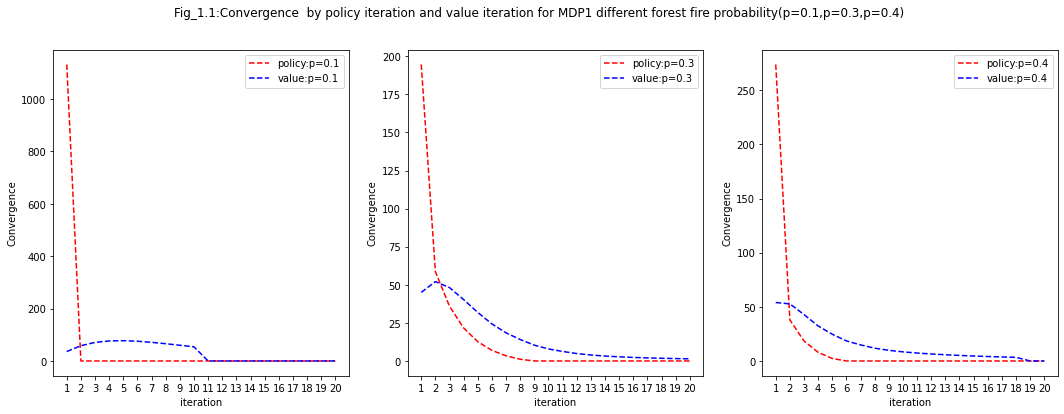

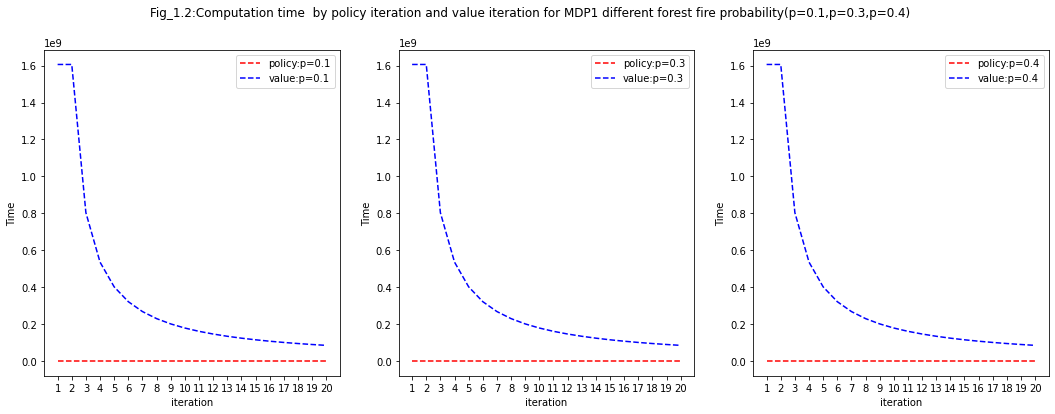

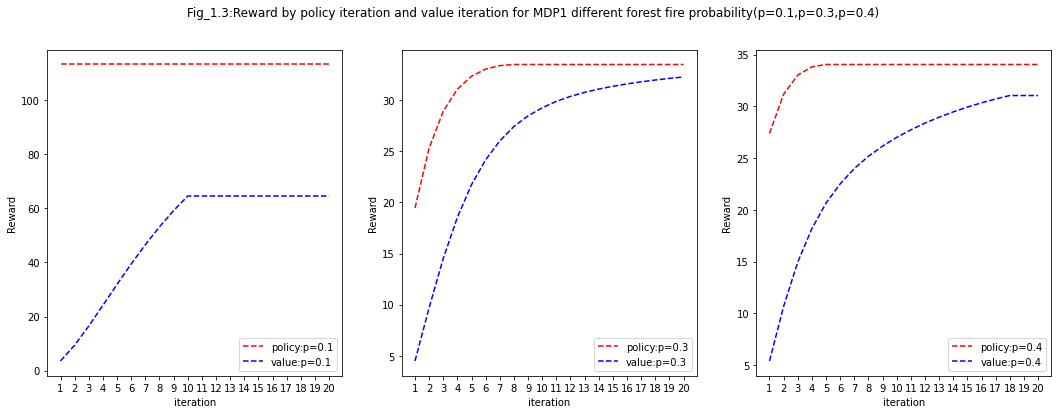

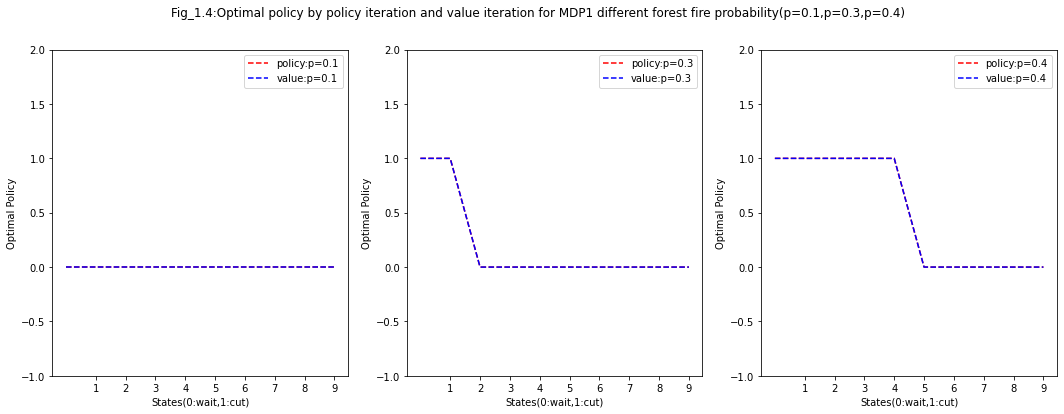

In [171]:
############MDP1 policy iteration and value iteration with different P#########
import matplotlib.pyplot as plt
S, r1, r2 = 10,36,18

p = [0.1,0.3,0.4]
iteration = 20

#########plot the graph of covergence,time,reward,policy solution########
fig_1,axs_1 = plt.subplots(1,3, figsize=(18, 6), sharey=False)
fig_1.suptitle("Fig_1.1:Convergence  by policy iteration and value iteration for MDP1 different forest fire probability(p=0.1,p=0.3,p=0.4)")
fig_2,axs_2 = plt.subplots(1,3, figsize=(18, 6), sharey=False)
fig_2.suptitle("Fig_1.2:Computation time  by policy iteration and value iteration for MDP1 different forest fire probability(p=0.1,p=0.3,p=0.4)")
fig_3,axs_3 = plt.subplots(1,3, figsize=(18, 6), sharey=False)
fig_3.suptitle("Fig_1.3:Reward by policy iteration and value iteration for MDP1 different forest fire probability(p=0.1,p=0.3,p=0.4)")
fig_4,axs_4 = plt.subplots(1,3, figsize=(18, 6), sharey=False)
fig_4.suptitle("Fig_1.4:Optimal policy by policy iteration and value iteration for MDP1 different forest fire probability(p=0.1,p=0.3,p=0.4)")
# axs_1.set_xlabel("iteration")
# axs_1.set_ylabel("Convergence")
# axs_2.set_xlabel("iteration")
# axs_2.set_ylabel("Time")
# axs_3.set_xlabel("iteration")
# axs_3.set_ylabel("Reward")
# axs_4.set_xlabel("States(0:wait,1:cut)")
# axs_4.set_ylabel("Optimal Policy")
# axs_4.set_ylim(-1,2)
fig = [fig_1,fig_2,fig_3,fig_4]
axs = [axs_1,axs_2,axs_3,axs_4]
fig = [fig_1,fig_2,fig_3,fig_4]
axs = [axs_1,axs_2,axs_3,axs_4]
for i in range(3):
    axs[0][i].set_xlabel("iteration")
    axs[0][i].set_ylabel("Convergence")
    axs[1][i].set_ylabel("Time")
    axs[1][i].set_xlabel("iteration")
    axs[2][i].set_xlabel("iteration")
    axs[2][i].set_ylabel("Reward")
    axs[3][i].set_xlabel("States(0:wait,1:cut)")
    axs[3][i].set_ylabel("Optimal Policy")
    axs[3][i].set_ylim(-1,2)
    axs[3][i].set_xticks(range(S))
    axs[0][i].set_xticks(range(1,iteration+1))
    axs[1][i].set_xticks(range(1,iteration+1))
    axs[2][i].set_xticks(range(1,iteration+1))
    axs[3][i].set_xticks(range(1,iteration+1))
    


color = ['r^','b^']
optimal_policy_p = []
for i in range(3):
    P,R = example.forest(S=S,r1 = r1,r2 = r2,p=p[i])
    for j in range(S):
        R[j][1] = i
    R[S-1][1] = 2*(S-1)
    R[S-1][0] = 2*R[S-1][1]
    #####policy iteration and value iteration######
    V_variation_p,V_variation_v = [],[]
    time_p, time_v = [],[]
    Reward_p, Reward_v = [],[]
    policy_p, policy_v =[],[]
    
    pi = mdp.PolicyIteration(P, R, 0.9, max_iter=1)
    vi = ValueIteration(P,R,0.9,max_iter=1)
    pi.run()
    vi.run()
    V_p_old = np.array(list(pi.V))
    V_v_old = np.array(list(vi.V))
    V_variation_p.append(np.sum(np.abs(V_p_old)))
    V_variation_v.append(np.sum(np.abs(V_v_old)))
    Reward_p.append(np.mean(V_p_old))
    Reward_v.append(np.mean(V_v_old))
    time_p.append(pi.time)
    time_v.append(vi.time)
    
    for j in range(1,iteration):
        pi = mdp.PolicyIteration(P, R, 0.9, max_iter=j+1)
        pi.run()
        vi = ValueIteration(P, R, 0.9, max_iter=j+1)
        vi.run()
        V_p_new = np.array(list(pi.V))
        V_v_new = np.array(list(vi.V))
        V_variation_p.append(np.sum(np.abs(V_p_old-V_p_new)))
        V_variation_v.append(np.sum(np.abs(V_v_old-V_v_new)))
        time_p.append(pi.time/j)
        time_v.append(vi.time/j)
        pi_hat = list(pi.policy)
        vi_hat = list(vi.policy)
        Reward_p.append(np.mean(V_p_new))
        Reward_v.append(np.mean(V_v_new))
        V_v_old = V_v_new
        V_p_old = V_p_new
    print(Reward_p[-1],Reward_v[-1])
    optimal_policy_p.append(pi.policy)  
#     print(V_variation_p)
#     print(Reward_p)
#     print(time_p)
    axs[0][i].plot(range(1,iteration+1),V_variation_p,'r',linestyle = "--",label='policy:p=%s'%p[i])
    axs[0][i].plot(range(1,iteration+1),V_variation_v,'b',linestyle = "--",label='value:p=%s'%p[i])
    axs[1][i].plot(range(1,iteration+1),time_p,'r',linestyle = "--",label='policy:p=%s'%p[i])
    axs[1][i].plot(range(1,iteration+1),time_v,'b',linestyle = "--",label='value:p=%s'%p[i])
    axs[2][i].plot(range(1,iteration+1),Reward_p,'r',linestyle = "--",label='policy:p=%s'%p[i])
    axs[2][i].plot(range(1,iteration+1),Reward_v,'b',linestyle = "--",label='value:p=%s'%p[i])
    axs[3][i].plot(range(S),list(pi.policy),'r',linestyle = "--",label='policy:p=%s'%p[i])
    axs[3][i].plot(range(S),list(vi.policy),'b',linestyle = "--",label='value:p=%s'%p[i])
for i in range(4):
    for j in range(3):
        axs[i][j].legend()
fig_1.savefig("Fig_1.1:Convergence by policy iteration and value iteration for MDP1 different forest fire probability(p=0.1,p=0.25,p=0.4).png")
fig_2.savefig("Fig_1.2:Computation time  by policy iteration and value iteration for MDP1 different forest fire probability(p=0.1,p=0.25,p=0.4).png")
fig_3.savefig("Fig_1.3:Reward  by policy iteration and value iteration for MDP1 different forest fire probability(p=0.1,p=0.25,p=0.4).png")
fig_4.savefig("Fig_1.4:Optimal policy by policy iteration and value iteration for MDP1 different forest fire probability(p=0.1,p=0.25,p=0.4).png")




In [169]:
V_v_new[-1],V_p_new[-1]

(90.9100240711071, 93.91304347826089)

['alpha:1/n,epsilon:1/log(n+2)', 'alpha:1/n,epsilon:1/n', 'alpha:1/nlog(n+2),epsilon:1/log(n+2)', 'alpha:1/nlog(n+2),epsilon:1/n']
0 0
converged
1.0
0 1
converged
1.0
1 0
converged
1.0
1 1
converged
1.0
0 0
converged
78.0
0 1
converged
51.0
1 0
converged
26.0
1 1
converged
23.0
0 0
not coverged
100.0
0 1
converged
92.0
1 0
converged
39.0
1 1
converged
30.0


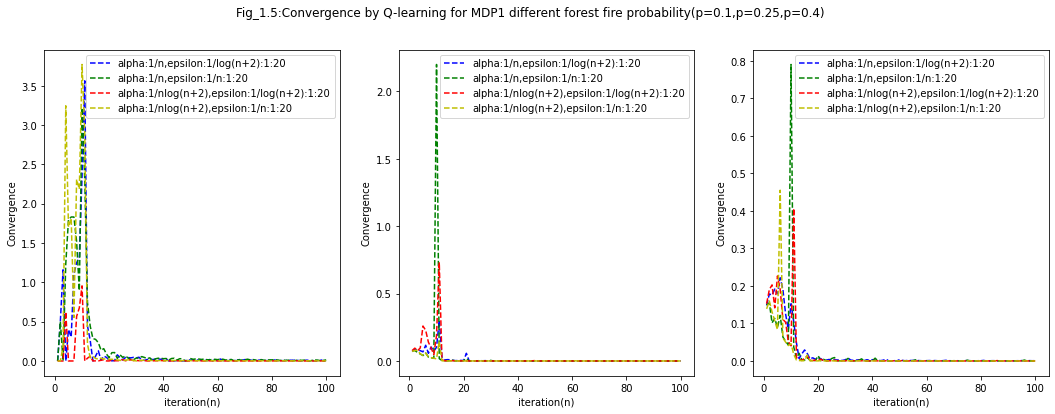

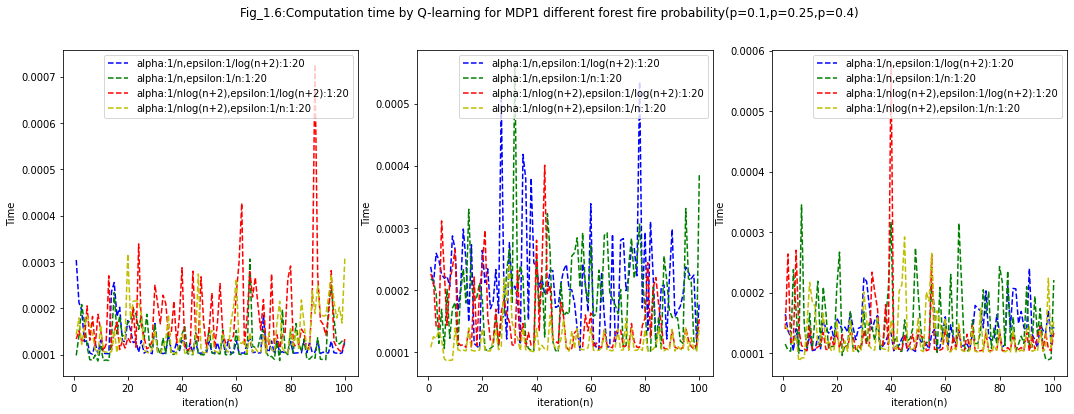

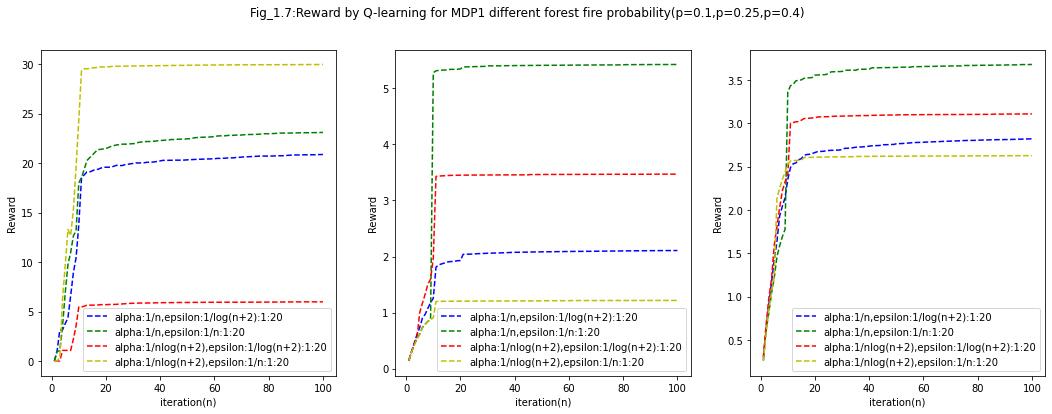

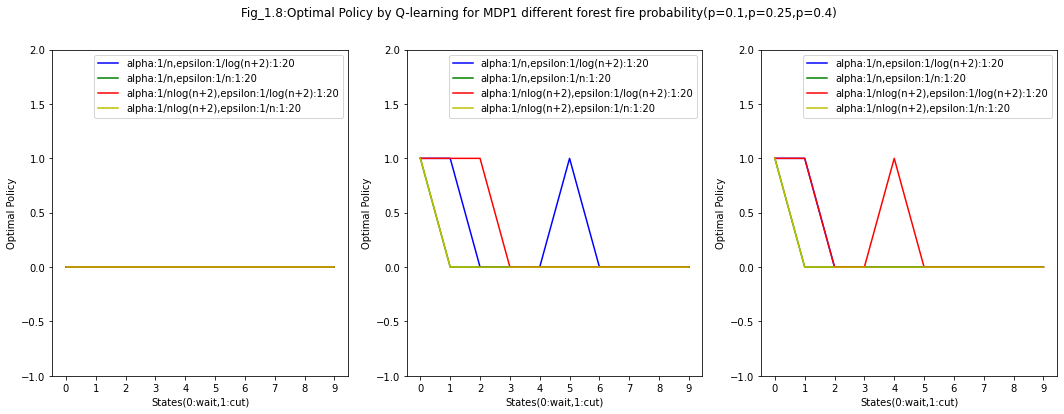

In [129]:
############MDP1 Q_learning with different fire probability,apha = 1/sqrt(n+2),epislon = 1/n#########
import matplotlib.pyplot as plt
S, r1, r2 = 10,36,18
p = [0.1,0.3,0.4]
iteration = 100

#########plot the graph of covergence,time,reward,policy solution########
fig_1,axs_1 = plt.subplots(1,3, figsize=(18, 6), sharey=False)
fig_1.suptitle("Fig_1.5:Convergence by Q-learning for MDP1 different forest fire probability(p=0.1,p=0.25,p=0.4)")
# fig_1[1].suptitle("Fig_3.1:Convergence by Q-learning for different forest fire probability(p=0.25)")
# fig_1[2].suptitle("Fig_3.1:Convergence by Q-learning for different forest fire probability(p=0.4)")
fig_2,axs_2 = plt.subplots(1,3, figsize=(18, 6), sharey=False)
fig_2.suptitle("Fig_1.6:Computation time by Q-learning for MDP1 different forest fire probability(p=0.1,p=0.25,p=0.4)")
fig_3,axs_3 = plt.subplots(1,3, figsize=(18, 6), sharey=False)
fig_3.suptitle("Fig_1.7:Reward by Q-learning for MDP1 different forest fire probability(p=0.1,p=0.25,p=0.4)")
fig_4,axs_4 = plt.subplots(1,3, figsize=(18, 6), sharey=False)
fig_4.suptitle("Fig_1.8:Optimal Policy by Q-learning for MDP1 different forest fire probability(p=0.1,p=0.25,p=0.4)")
fig = [fig_1,fig_2,fig_3,fig_4]
axs = [axs_1,axs_2,axs_3,axs_4]
for i in range(3):
    axs[0][i].set_xlabel("iteration(n)")
    axs[0][i].set_ylabel("Convergence")
    axs[1][i].set_ylabel("Time")
    axs[1][i].set_xlabel("iteration(n)")
    axs[2][i].set_xlabel("iteration(n)")
    axs[2][i].set_ylabel("Reward")
    axs[3][i].set_xlabel("States(0:wait,1:cut)")
    axs[3][i].set_ylabel("Optimal Policy")
    axs[3][i].set_ylim(-1,2)
    axs[3][i].set_xticks(range(S))
# for i in range(3):
#     axs[i].set_xticks(range(1,iteration+1))

t=S*2*10
color = ['b','g','r','y','k','pink','m','aqua','mediumvioletred']
alpha_n = [lambda n: 0.1 if n<t else 1/(n-t+1),lambda n: 0.1 if n<t else 1/((n-t+1)*_math.log(n-t + 3))]
# epsilon_n = [lambda n: 0.1 if n <t else 1/_math.log(n-t+ 3), lambda n: 0.1 if n <t else 1/(n-t+1),lambda n: 0.1 if n<t else 1/((n-t+1)**2)]
# epsilon = [lambda n: 0.1, lambda n: 0.3, lambda n:0.5]
epsilon_n = [lambda n: 1/_math.log(n+2),lambda n: 1/n]
alpha_name = ['1/n','1/nlog(n+2)']
epsilon_name = ['1/log(n+2)','1/n']
LE_rate = ['alpha:'+a+',epsilon:'+b for a in alpha_name for b in epsilon_name]
print(LE_rate)
QL =[]
Reward =[]
for i in range(3):
    P,R = example.forest(S=S,r1 = r1,r2 = r2,p=p[i])
    for j in range(S):
        R[j][1] = i
    R[S-1][1] = 2*(S-1)
    R[S-1][0] = 2*R[S-1][1]
    QL_p = []
    #####Q-learning######
    k,j=0,0
    for alpha in alpha_n:
        for epsilon in epsilon_n:
            kwargs = {'alpha_t':alpha,'epsilon_t':epsilon}
            print(k,j)
            ql = QLearning(P, R, 0.9, n_iter=iteration,**kwargs)
            ql.run()
            QL_p.append((list(ql.policy),ql.coverged))
           
            Reward.append(ql.Reward_by_iteration[-1])
#             print(ql.Reward_by_iteration[-1])
            axs[0][i].plot(range(1,iteration+1),ql.mean_discrepancy,color[j+k*2],linestyle = "--",label=LE_rate[j+k*2]+":1:%d"%(S*2))
            axs[1][i].plot(range(1,iteration+1),ql.time,color[j+2*k],linestyle = "--",label=LE_rate[j+k*2]+":1:%d"%(S*2))
            axs[2][i].plot(range(1,iteration+1),ql.Reward_by_iteration,color[j+2*k],linestyle = "--",label=LE_rate[j+k*2]+":1:%d"%(S*2))
            axs[3][i].plot(range(S),list(ql.policy),color[j+2*k],label=LE_rate[j+k*2]+":1:%d"%(S*2))
            j+=1
        k+=1
        j=0
    QL.append(QL_p)
#     axs[0][i].plot(range(1,iteration+1),ql_2.mean_discrepancy,color[i],linestyle = "--",label=LE_rate[1])
#     axs[0][i].plot(range(1,iteration+1),ql_3.mean_discrepancy,color[i],linestyle = "--",label=LE_rate[2])
        
#     axs[1][i].plot(range(1,iteration+1),ql_2.time,color[i],linestyle = "--",label=LE_rate[1])
#     axs[1][i].plot(range(1,iteration+1),ql_3.time,color[i],linestyle = "--",label=LE_rate[2])
        
#     axs[2][i].plot(range(1,iteration+1),ql_2.Reward_by_iteration,color[i],linestyle = "--",label=LE_rate[1])
#     axs[2][i].plot(range(1,iteration+1),ql_3.Reward_by_iteration,color[i],linestyle = "--",label=LE_rate[2])
        
#     axs[3][i].plot(range(S),list(ql_2.policy),color[i],linestyle = "--",label=LE_rate[1])
#     axs[3][i].plot(range(S),list(ql_3.policy),color[i],linestyle = "--",label=LE_rate[2])
for i in range(4):
    for j in range(3):
        axs[i][j].legend()
fig_1.savefig("Fig_1.5:Convergence by Q-learning for MDP1 different forest fire probability(p=0.1,p=0.25,p=0.4).png")
fig_2.savefig("Fig_1.6:Time by Q-learning for MDP1 different forest fire probability(p=0.1,p=0.25,p=0.4).png")
fig_3.savefig("Fig_1.7:Reward by Q-learning for MDP1 different forest fire probability(p=0.1,p=0.25,p=0.4).png")
fig_4.savefig("Fig_1.8:Optimal policy by Q-learning for MDP1 different forest fire probability(p=0.1,p=0.25,p=0.4).png")




In [166]:
print(QL)
def vote_for_policy(PI,a):
    optima_pi =[]
    for j in range(len(PI[0][0])):
        num_a = [0 for i in range(a)]
        for (pi,coverged) in PI:
#             if coverged:
            num_a[pi[j]]+=1
        optima_pi.append(np.argmax(np.array(num_a)))
    return optima_pi       
###compute the voted optimal policy
optimal_policy_vote_p1 = vote_for_policy(QL[0],2)
optimal_policy_vote_p2 = vote_for_policy(QL[1],2)
optimal_policy_vote_p3 = vote_for_policy(QL[2],2)
##compute the difference before and after voting
diff_vp1 = np.sum(np.abs(np.array(optimal_policy_vote_p1)-np.array(optimal_policy_p[0])))
diff_vp2 = np.sum(np.abs(np.array(optimal_policy_vote_p2)-np.array(optimal_policy_p[1])))
diff_vp3 = np.sum(np.abs(np.array(optimal_policy_vote_p3)-np.array(optimal_policy_p[2])))
diff_qp1 = np.sum([np.abs(np.array(QL[0][i][0])-np.array(optimal_policy_p[0])) for i in range(4)])/4
diff_qp2 = np.sum([np.abs(np.array(QL[1][i][0])-np.array(optimal_policy_p[1])) for i in range(4)])/4
diff_qp3 = np.sum([np.abs(np.array(QL[2][i][0])-np.array(optimal_policy_p[2])) for i in range(4)])/4

##compare the difference
print(diff_vp1,diff_qp1)
print(diff_vp2,diff_qp2)
print(diff_vp3,diff_qp3)
# print(diff_vp1_5,diff_qp1)
# print(diff_vp2_7,diff_qp2)
print(optimal_policy_vote_p1)
print(optimal_policy_vote_p2)
print(optimal_policy_vote_p3)

[[([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], True), ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], True), ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], True), ([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], True)], [([1, 1, 0, 0, 0, 1, 0, 0, 0, 0], True), ([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], True), ([1, 1, 1, 0, 0, 0, 0, 0, 0, 0], True), ([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], True)], [([1, 1, 0, 0, 0, 0, 0, 0, 0, 0], False), ([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], True), ([1, 1, 0, 0, 1, 0, 0, 0, 0, 0], True), ([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], True)]]
0 0.0
1 1.0
4 3.25
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
print(np.sum(np.abs(np.array(QL[2][0][0])-np.array(optimal_policy_p[2]))))     
print(np.sum(np.abs(np.array(QL[2][1][0])-np.array(optimal_policy_p[2]))))         
print(np.sum(np.abs(np.array(QL[2][2][0])-np.array(optimal_policy_p[2]))))    

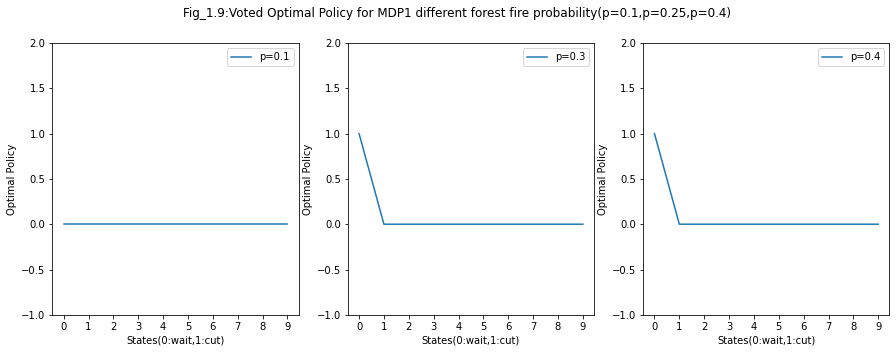

In [167]:
###generate the voted policy
fig,axs = plt.subplots(1,3, figsize=(15, 5), sharey=False)
axs[0].plot(range(S),optimal_policy_vote_p1,label='p=0.1')
axs[1].plot(range(S),optimal_policy_vote_p2,label='p=0.3')
axs[2].plot(range(S),optimal_policy_vote_p3,label='p=0.4')
for i in range(3):
    axs[i].set_xlabel("States(0:wait,1:cut)")
    axs[i].set_ylabel("Optimal Policy")
    axs[i].set_ylim(-1,2)
    axs[i].set_xticks(range(S))
    axs[i].legend()
fig.suptitle("Fig_1.9:Voted Optimal Policy for MDP1 different forest fire probability(p=0.1,p=0.25,p=0.4)")
fig.savefig("Fig_1.9:Voted Optimal Policy for MDP1 different forest fire probability(p=0.1,p=0.25,p=0.4).png")

In [ ]:
##generate MDP2 grid
def generate_grid(n=20): 
    board = []
    for row in range(n):
        board.append([])
        for column in range(n):
            board[row].append('-')
    board[0][n-1] = 'G'  
    board[n-1][0] = 'S'
    for i in range(1,n-1):
        board[1][i] = 'x'
    for i in range(1,n-4):
        board[i][1] ='x'
    
    for i in range(1,n-1):
        if i%3 == 0:
            board[2][i] = 'x'
            board[3][i] ='x'
        if i < 6:
            board[6][i] ='x'
    for i in range(n-2,n-7,-1):
        board[7][i] ='x'
    for i in range(10,18):
        board[i][9] ='x'
    for i in range(18,13,-1):
        board[i][4] ='x'
        board[i][17] ='x'
    for i in range(4,18):
        board[18][i] ='x'
    board[14][18] = 'x'
    board[14][19] ='x'
    return board
grid = generate_grid()
S = 0
for i in range(20):
    for j in range(20):
        if grid[i][j] != 'x':
            S += 1
def print_board(board):
    for row in board:
        print(" ".join(row))
print_board(grid)
print(S)

In [ ]:
####generate P and R
actions = {"W": 0,"E":1, "N":2,"S":3}
global grid_dim 
grid_dim= 20
a = 4
P = np.zeros((4,S,S))
R = np.zeros((S,a))
def get_probability(grid_to_num,i,j,a,S):
    if grid_to_num[i][j] == -1: return
    state_board = np.zeros((grid_dim,grid_dim))
    for k in range(grid_dim):
        for t in range(grid_dim):
            state_board[k][t] = grid_to_num[k][t]
    if a == 0:
        ##west
        if j>0 and state_board[i][j-1] !=-1:
            state_board[i][j-1] = 0.8
        else:
            state_board[i][j] += 0.8
        if i>0 and state_board[i-1][j] != -1:
            state_board[i-1][j] = 0.1
        else:
            state_board[i][j] += 0.1
        if i<19 and state_board[i+1][j] !=-1:
            state_board[i+1][j] = 0.1
        else:
            state_board[i][j] +=0.1
    if a == 1:
        ##east
        if j < 19 and state_board[i][j+1] != -1:
            state_board[i][j+1] = 0.8
        else:
            state_board[i][j] += 0.8
        if i>0 and state_board[i-1][j]!=-1:
            state_board[i-1][j] = 0.1
        else:
            state_board[i][j] += 0.1
        if i<19 and state_board[i+1][j]!=-1:
            state_board[i+1][j] = 0.1
        else:
            state_board[i][j] +=0.1
            
    if a == 2:
        ##north
        if i >0 and state_board[i-1][j]!=-1:
            state_board[i-1][j] = 0.8
        else:
            state_board[i][j] += 0.8
        if j>0 and state_board[i][j-1]!=-1:
            state_board[i][j-1] = 0.1
        else:
            state_board[i][j] +=0.1
        if j<19 and state_board[i][j+1]!=-1:
            state_board[i][j+1] =0.1
        else:
            state_board[i][j] += 0.1
    if a==3:
        #south
        if i< 19 and state_board[i+1][j] !=-1:
            state_board[i+1][j] = 0.8
        else:
            state_board[i][j] += 0.8
        if j>0 and state_board[i][j-1] != -1:
            state_board[i][j-1] = 0.1
        else:
            state_board[i][j] +=0.1
        if j<19 and state_board[i][j+1]!=-1:
            state_board[i][j+1] =0.1
        else:
            state_board[i][j] += 0.1
    probability_vector = []
    for i in range(grid_dim):
        for j in range(grid_dim):
            if state_board[i][j]!= -1:
                probability_vector.append(state_board[i][j])
    print(len(probability_vector))
# #     if len(probability_vector)==311:
# #         print("wrong!",i,j)
#     print(sum(probability_vector))    
    return probability_vector

grid_to_num = np.zeros((grid_dim,grid_dim))
for i in range(grid_dim):
    for j in range(grid_dim):
        if grid[i][j] =='x':
            grid_to_num[i][j] = -1
        else:
            grid_to_num[i][j] = 0

for a in range(4):
    prob_matrix_a = []
    for i in range(20):
        for j in range(20):
            if grid_to_num[i][j] != -1:
                vector = get_probability(grid_to_num,i,j,a,S)
                prob_matrix_a.append(vector)
    
    P[a] = np.array(prob_matrix_a)
RT=R.T
for a in range(4):
    r =[]
    for i in range(grid_dim):
        for j in range(grid_dim):
            if grid_to_num[i][j]!=-1:
                if i==0 and j ==19:
#                 if (i==0 and j==1 and a==2) or (i==1 and j==19 and a==3):
                    r.append(400)
                else:
                    r.append(-1)
    print(r)
    RT[a] = np.array(r)
R = RT.T
print(R)
def generate_policy_graph(policy):
    t=0
    policy_graph = []
    for i in range(20):
        policy_graph.append([]) 
        for j in range(20):
            if grid_to_num[i][j] == -1:
                policy_graph[i].append('x')
            else:
                a = policy[t]
                if a == 0:
                    policy_graph[i].append("W")
                elif a == 1:
                    policy_graph[i].append("E")
                elif a ==2:
                    policy_graph[i].append("N")
                else:
                    policy_graph[i].append("S")
                t += 1              
    return policy_graph
def generate_value_graph(V):
    t=0
    value_graph = []
    for i in range(20):
        value_graph.append([]) 
        for j in range(20):
            if grid_to_num[i][j] == -1:
                value_graph[i].append('x')
            else:
                v = V[t]
                value_graph[i].append(str(round(v,0)))
                t += 1
    return value_graph
            
       

In [ ]:
P

In [ ]:
############MDP2 policy iteration and value iteration#########
import matplotlib.pyplot as plt

iteration = 60

#########plot the graph of covergence,time,reward,policy solution########
fig_1,axs_1 = plt.subplots(1,1, figsize=(6, 6), sharey=False)
fig_1.suptitle("Fig_2.1:Convergence  by policy iteration and value iteration for MDP2")
fig_2,axs_2 = plt.subplots(1,1, figsize=(6, 6), sharey=False)
fig_2.suptitle("Fig_2.2:Computation time  by policy iteration and value iteration for MDP2")
fig_3,axs_3 = plt.subplots(1,1, figsize=(6, 6), sharey=False)
fig_3.suptitle("Fig_2.3:Reward by policy iteration and value iteration for MDP2")
# fig_4,axs_4 = plt.subplots(1,1, figsize=(6, 6), sharey=False)
# fig_4.suptitle("Fig_2.4:Optimal policy by policy iteration and value iteration for MDP2")
axs_1.set_xlabel("iteration")
axs_1.set_ylabel("Convergence")
axs_2.set_xlabel("iteration")
axs_2.set_ylabel("Time")
axs_3.set_xlabel("iteration")
axs_3.set_ylabel("Reward")
# axs_4.set_xlabel("States(0:wait,1:cut)")
# axs_4.set_ylabel("Optimal Policy")
# axs_4.set_ylim(-1,2)
fig = [fig_1,fig_2,fig_3,fig_4]
axs = [axs_1,axs_2,axs_3,axs_4]


color = ['r^','b^']


#####policy iteration and value iteration######
V_variation_p,V_variation_v = [],[]
time_p, time_v = [],[]
Reward_p, Reward_v = [],[]
policy_p, policy_v =[],[]

pi = mdp.PolicyIteration(P, R, 0.9, max_iter=1)
vi = ValueIteration(P,R,0.9,max_iter=1)
pi.run()
vi.run()
V_p_old = np.array(list(pi.V))
V_v_old = np.array(list(vi.V))
V_variation_p.append(np.sum(np.abs(V_p_old)))
V_variation_v.append(np.sum(np.abs(V_v_old)))
Reward_p.append(np.mean(V_p_old))
Reward_v.append(np.mean(V_v_old))
time_p.append(pi.time)
time_v.append(vi.time)

for j in range(1,iteration):
    pi = mdp.PolicyIteration(P, R, 0.9, max_iter=j+1)
    pi.run()
    vi = ValueIteration(P, R, 0.9, max_iter=j+1)
    vi.run()
    V_p_new = np.array(list(pi.V))
    V_v_new = np.array(list(vi.V))
    V_variation_p.append(np.sum(np.abs(V_p_old-V_p_new)))
    V_variation_v.append(np.sum(np.abs(V_v_old-V_v_new)))
    time_p.append(pi.time/j)
    time_v.append(vi.time/j)
    Reward_p.append(np.mean(V_p_new))
    Reward_v.append(np.mean(V_v_new))
    V_v_old = V_v_new
    V_p_old = V_p_new
optima_policy = list(pi.policy)
#     print(V_variation_p)
#     print(Reward_p)
#     print(time_p)
axs[0].plot(range(1,iteration+1),V_variation_p,'r',linestyle = "--",label='policy iteration')
axs[0].plot(range(1,iteration+1),V_variation_v,'b',linestyle = "--",label='value iteration')
axs[1].plot(range(1,iteration+1),time_p,'r',linestyle = "--",label='policy iteration')
axs[1].plot(range(1,iteration+1),time_v,'b',linestyle = "--",label='value iteration')
axs[2].plot(range(1,iteration+1),Reward_p,'r',linestyle = "--",label='policy iteration')
axs[2].plot(range(1,iteration+1),Reward_v,'b',linestyle = "--",label='value iteration')
#     axs[3].plot(range(S),list(pi.policy),'r',linestyle = "--",label='policy iteration')
#     axs[3].plot(range(S),list(vi.policy),'b',linestyle = "--",label='value iteration')
for i in range(3):
    axs[i].legend()
fig_1.savefig("Fig_2.1:Convergence by policy iteration and value iteration for MDP2.png")
fig_2.savefig("Fig_2.2:Computation time by policy iteration and value iteration for MDP2.png")
fig_3.savefig("Fig_2.3:Reward by policy iteration and value iteration for MDP2.png")
# fig_4.savefig("Fig_2.4:Optimal policy by policy iteration and value iteration for MDP2.png")

policy_pi = list(pi.policy)
policy_vi = list(vi.policy)


policy_graph_pi = generate_policy_graph(policy_pi)
policy_graph_vi = generate_policy_graph(policy_vi)
print_board(policy_graph_pi)
print("*********************")
print_board(policy_graph_vi)



In [ ]:
Reward_v[0],Reward_p[0]

In [ ]:
policy_pi = list(pi.policy)
policy_vi = list(vi.policy)


policy_graph_pi = generate_policy_graph(policy_pi)
policy_graph_vi = generate_policy_graph(policy_vi)
print_board(policy_graph_pi)
print("*********************")
print_board(policy_graph_vi)

In [ ]:
for i in range(S):
    if policy_pi[i] != policy_vi[i]:
        print(i)

In [ ]:
############MDP2 Q_learning with different fire probability,apha = 1/sqrt(n+2),epislon = 1/n#########

iteration = 1000

#########plot the graph of covergence,time,reward,policy solution########
fig_1,axs_1 = plt.subplots(1,1, figsize=(10, 6), sharey=False)
fig_1.suptitle("Fig_2.5:Convergence by Q-learning for MDP2")

fig_2,axs_2 = plt.subplots(1,1, figsize=(10, 6), sharey=False)
fig_2.suptitle("Fig_2.6:Computation time by Q-learning for MDP2")
fig_3,axs_3 = plt.subplots(1,1, figsize=(10, 6), sharey=False)
fig_3.suptitle("Fig_2.7:Reward by Q-learning for MDP2")

axs_1.set_xlabel("iteration")
axs_1.set_ylabel("Convergence")
axs_2.set_xlabel("iteration")
axs_2.set_ylabel("Time")
axs_3.set_xlabel("iteration")
axs_3.set_ylabel("Reward")
# axs_4.set_xlabel("States(0:wait,1:cut)")
# axs_4.set_ylabel("Optimal Policy")
# axs_4.set_ylim(-1,2)
fig = [fig_1,fig_2,fig_3,fig_4]
axs = [axs_1,axs_2,axs_3,axs_4]

# for i in range(3):
#     axs[i].set_xticks(range(1,iteration+1))


color = ['b','g','r','y','k','pink','m','aqua','mediumvioletred']
alpha_n = [lambda n: 1/n,lambda n: 1/(n*_math.sqrt(n)),lambda n: 1/n*n]
epsilon_n = [lambda n: 1 / _math.log(n + 2), lambda n: 1/n, lambda n: 1/n*_math.log(n+2)]
alpha_name = ['1/n','1/n^3/2','1/n^2']
epsilon_name = ['1/log(n+2)','1/n','1/n^2']
LE_rate = ['alpha:'+a+',epsilon:'+b for a in alpha_name for b in epsilon_name]
print(LE_rate)


#####Q-learning######
QL = []
k,j=0,0
Reward =[]
for alpha in alpha_n:
    for epsilon in epsilon_n:
        kwargs = {'alpha_t':alpha,'epsilon_t':epsilon}
        ql = QLearning(P, R, 0.9, n_iter=iteration,**kwargs)
        ql.run()
        QL.append((list(ql.policy),ql.coverged))
        print(k,j)
        Reward.append(ql.Reward_by_iteration[-1])
        print(ql.Reward_by_iteration[-1])
        axs[0].plot(range(1,iteration+1),ql.mean_discrepancy,color[j+k*3],linestyle = "--",label=LE_rate[j+k*3])
        axs[1].plot(range(1,iteration+1),ql.time,color[j+3*k],linestyle = "--",label=LE_rate[j+k*3])
        axs[2].plot(range(1,iteration+1),ql.Reward_by_iteration,color[j+3*k],linestyle = "--",label=LE_rate[j+k*3])
#         axs[3][i].plot(range(S),list(ql.policy),color[j+3*k],label=LE_rate[j+k*3])
        j+=1
    k+=1
    j=0
#     axs[0][i].plot(range(1,iteration+1),ql_2.mean_discrepancy,color[i],linestyle = "--",label=LE_rate[1])
#     axs[0][i].plot(range(1,iteration+1),ql_3.mean_discrepancy,color[i],linestyle = "--",label=LE_rate[2])

#     axs[1][i].plot(range(1,iteration+1),ql_2.time,color[i],linestyle = "--",label=LE_rate[1])
#     axs[1][i].plot(range(1,iteration+1),ql_3.time,color[i],linestyle = "--",label=LE_rate[2])

#     axs[2][i].plot(range(1,iteration+1),ql_2.Reward_by_iteration,color[i],linestyle = "--",label=LE_rate[1])
#     axs[2][i].plot(range(1,iteration+1),ql_3.Reward_by_iteration,color[i],linestyle = "--",label=LE_rate[2])

#     axs[3][i].plot(range(S),list(ql_2.policy),color[i],linestyle = "--",label=LE_rate[1])
#     axs[3][i].plot(range(S),list(ql_3.policy),color[i],linestyle = "--",label=LE_rate[2])
for i in range(3):
    axs[i].legend()
fig_1.savefig("Fig_2.5:Convergence by Q-learning for MDP2.png")
fig_2.savefig("Fig_2.6:Time by Q-learning for MDP2.png")
fig_3.savefig("Fig_2.7:Reward by Q-learning for MDP2.png")
# fig_4.savefig("Fig_2.4:Optimal policy by Q-learning for different forest fire probability(p=0.1,p=0.25,p=0.4).png")




In [ ]:
##print the 9 Q-learning optima policy
for ql,converged in QL:
    policy_graph_ql = generate_policy_graph(ql)
    print_board(policy_graph_ql)
    print('________________')
#
###compute the voted optimal policy
optima_voted_policy = vote_for_policy(QL,4)
optima_voted_policy_graph = generate_policy_graph(optima_voted_policy)
print_board(optima_voted_policy_graph)

In [ ]:
  
##compute the difference before and after voting
diff_v = np.sum(np.abs(np.array(optima_voted_policy)-np.array(optima_policy)))
diff_q = np.sum([np.abs(np.array(QL[i][0])-np.array(optima_policy)) for i in range(9)])/9

##compare the difference
print(diff_v,diff_q)

In [ ]:
print_board(optima_voted_policy_graph)

In [ ]:
np.sum(np.abs(np.array(QL[3][0])-np.array(optima_policy)))